## Data Analysis

This notebook will serve as study for our data.

## Introduction

A **CNC (Computer Numerical Control)** machine is an automated system that performs precise mechanical operations such as cutting, milling, or drilling.  
It executes instructions encoded in numerical form to control the position, rotation, and speed of its mechanical components.  
Because of their precision and continuous operation, CNC systems are widely used in manufacturing, but they are also subject to mechanical wear, heat accumulation, and component failures over time.

Monitoring a CNC involves multiple **sensors** — for example:
- **Spindle temperature** to detect overheating,
- **Vibration RMS** to detect imbalance or bearing wear,
- **Coolant flow rate** to ensure efficient cooling,
- **Power and load** to measure operating stress.

These sensor readings generate large volumes of data over time.  
The goal of the **Hybrid CNC Failure Diagnosis System** is to use this data, combined with structured expert knowledge, to automatically **detect abnormal patterns, infer root causes of failure, and recommend the optimal maintenance action**.

---

## Project Purpose

This project aims to create a **hybrid diagnostic framework** that combines:
1. **Bayesian Networks (BN)** — a probabilistic model that learns relationships between sensor readings and underlying causes (e.g., bearing wear, clogged filter, fan fault).
2. **Knowledge Graphs (KG)** — a semantic model that stores structured knowledge about components, causes, symptoms, and maintenance procedures.

Together, they allow reasoning such as:

> “Given the observed vibration and temperature, what is the probability that the spindle is overheating due to a clogged filter,  
> and what maintenance action should be performed?”


In [2]:

# === Setup ===
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib inline

DATA_DIR = "/mnt/data"
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 120)



In [4]:
# === 1. Load all CSVs ===
import os
import pandas as pd

DATA_DIR = "data"  # your CSVs are inside ./data/

files = [
    "causes", "components", "labels", "maintenance",
    "procedures", "relations", "symptoms", "telemetry"
]

dfs = {}
for f in files:
    path = os.path.join(DATA_DIR, f"{f}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        dfs[f] = df
        print(f"Loaded {f}: {len(df)} rows, {len(df.columns)} columns")
    else:
        dfs[f] = None
        print(f"{f} missing")

Loaded causes: 4 rows, 2 columns
Loaded components: 5 rows, 4 columns
Loaded labels: 103680 rows, 3 columns
Loaded maintenance: 23 rows, 5 columns
Loaded procedures: 4 rows, 7 columns
Loaded relations: 8 rows, 3 columns
Loaded symptoms: 3 rows, 2 columns
Loaded telemetry: 103680 rows, 11 columns


In [9]:
# === 2. Quick schema overview ===
for name, df in dfs.items():
    if df is not None:
        print(f"\n=== {name.upper()} ===")
        print(df.info())
        print("Null counts:\n", df.isna().sum())
        print("Sample:\n", df.head(3))


=== CAUSES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cause_id  4 non-null      object
 1   name      4 non-null      object
dtypes: object(2)
memory usage: 196.0+ bytes
None
Null counts:
 cause_id    0
name        0
dtype: int64
Sample:
   cause_id             name
0       K1  BearingWearHigh
1       K2         FanFault
2       K3    CloggedFilter

=== COMPONENTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   component_id      5 non-null      object
 1   name              5 non-null      object
 2   parent_component  3 non-null      object
 3   function          5 non-null      object
dtypes: object(4)
memory usage: 292.0+ bytes
None
Null counts:
 component_id        0
name                0
pa

In [10]:
# === 3. Components structure ===
comp = dfs["components"]
if comp is not None:
    print("\nComponent hierarchy:")
    display(comp[["component_id", "name", "parent_component", "function"]])
    if "parent_component" in comp.columns:
        print("\nParent distribution:\n", comp["parent_component"].value_counts(dropna=False))


Component hierarchy:


,component_id,name,parent_component,function
0,C1,Spindle,NaN,Rotate tool
1,C2,CoolingSystem,NaN,Dissipate heat
2,C3,Fan,C2,Air flow
3,C4,Filter,C2,Filter coolant/air
4,C5,Bearing,C1,Support rotation



Parent distribution:
 parent_component
NaN    2
C2     2
C1     1
Name: count, dtype: int64


In [11]:
# === 4. Causes ===
causes = dfs["causes"]
if causes is not None:
    print("\nUnique causes:", len(causes))
    display(causes)


Unique causes: 4


,cause_id,name
0,K1,BearingWearHigh
1,K2,FanFault
2,K3,CloggedFilter
3,K4,LowCoolingEfficiency


In [12]:
# === 5. Symptoms ===
sym = dfs["symptoms"]
if sym is not None:
    print("\nSymptoms summary:")
    print(sym.describe(include="all"))
    print("\nTop 10 symptom names:\n", sym["name"].value_counts().head(10))


Symptoms summary:
       symptom_id           name
count           3              3
unique          3              3
top            S1  HighVibration
freq            1              1

Top 10 symptom names:
 name
HighVibration      1
HighSpindleTemp    1
LowCoolantFlow     1
Name: count, dtype: int64


In [13]:
# === 6. Relations (links between entities) ===
rel = dfs["relations"]
if rel is not None:
    print("\nRelations preview:")
    display(rel.head(10))
    print("Unique relation types:", rel["relation_type"].nunique() if "relation_type" in rel.columns else "N/A")
    print("From entities:", rel["from"].nunique() if "from" in rel.columns else "N/A")
    print("To entities:", rel["to"].nunique() if "to" in rel.columns else "N/A")


Relations preview:


,subj,pred,obj
0,BearingWearHigh,causesSymptom,HighVibration
1,BearingWearHigh,affectsComponent,Bearing
2,FanFault,causesSymptom,HighSpindleTemp
3,FanFault,affectsComponent,Fan
4,CloggedFilter,causesSymptom,LowCoolantFlow
5,CloggedFilter,affectsComponent,Filter
6,LowCoolingEfficiency,causesSymptom,HighSpindleTemp
7,LowCoolingEfficiency,affectsComponent,CoolingSystem


Unique relation types: N/A
From entities: N/A
To entities: N/A


In [14]:
# === 7. Procedures ===
proc = dfs["procedures"]
if proc is not None:
    print("\nProcedures overview:")
    print(proc.describe(include="all"))
    if "action_type" in proc.columns:
        print("Action type frequency:\n", proc["action_type"].value_counts().head(10))


Procedures overview:
       proc_id            name targets_component  mitigates_cause  effort_h  \
count        4               4                 4                4  4.000000   
unique       4               4                 4                4       NaN   
top         P1  ReplaceBearing           Bearing  BearingWearHigh       NaN   
freq         1               1                 1                1       NaN   
mean       NaN             NaN               NaN              NaN  2.875000   
std        NaN             NaN               NaN              NaN  2.096624   
min        NaN             NaN               NaN              NaN  1.500000   
25%        NaN             NaN               NaN              NaN  1.875000   
50%        NaN             NaN               NaN              NaN  2.000000   
75%        NaN             NaN               NaN              NaN  3.000000   
max        NaN             NaN               NaN              NaN  6.000000   

        spare_parts_cost_eur 


Labels time coverage:
2025-01-01 00:00:00 → 2025-03-31 23:55:00
Machines: 4


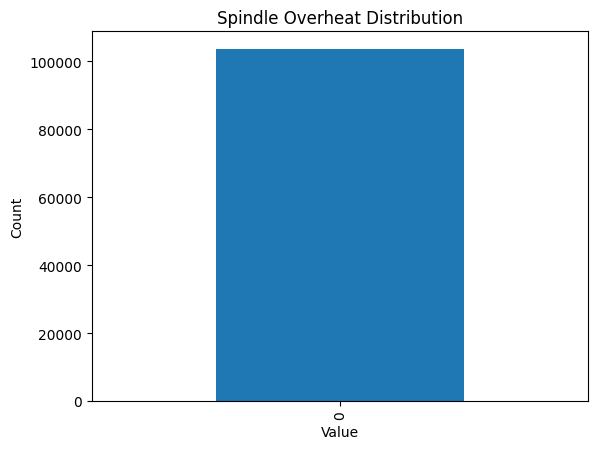

In [8]:
# === 8. Labels (events per machine over time) ===
lab = dfs["labels"]
if lab is not None:
    print("\nLabels time coverage:")
    print(lab["timestamp"].min(), "→", lab["timestamp"].max())
    print("Machines:", lab["machine_id"].nunique())
    if "spindle_overheat" in lab.columns:
        plt.figure()
        lab["spindle_overheat"].value_counts().plot(kind="bar")
        plt.title("Spindle Overheat Distribution")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.show()


Spindle_overheat value counts:
spindle_overheat
0    103680
Name: count, dtype: int64

Total zeros: 103680
Total ones:  0


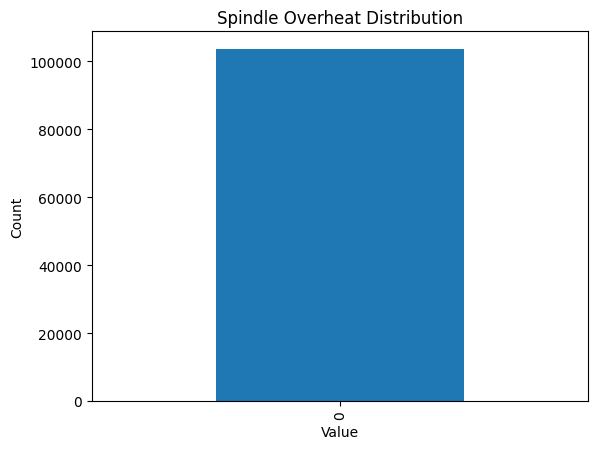

In [9]:
if "spindle_overheat" in lab.columns:
    counts = lab["spindle_overheat"].value_counts(dropna=False)
    print("\nSpindle_overheat value counts:")
    print(counts)
    print(f"\nTotal zeros: {counts.get(0, 0)}")
    print(f"Total ones:  {counts.get(1, 0)}")
    plt.figure()
    counts.sort_index().plot(kind="bar")
    plt.title("Spindle Overheat Distribution")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()



Telemetry columns: ['timestamp', 'machine_id', 'spindle_temp', 'ambient_temp', 'vibration_rms', 'coolant_flow', 'feed_rate', 'spindle_speed', 'load_pct', 'power_kw', 'tool_wear']
Telemetry time coverage:
2025-01-01 00:00:00 → 2025-03-31 23:55:00
Machines: 4

Numeric columns used for correlation: ['spindle_temp', 'ambient_temp', 'vibration_rms', 'coolant_flow', 'feed_rate', 'spindle_speed', 'load_pct', 'power_kw', 'tool_wear']

Correlation matrix (top 10 cols):
                spindle_temp  ambient_temp  vibration_rms  coolant_flow  \
spindle_temp       1.000000      0.280549       0.731864     -0.127355   
ambient_temp       0.280549      1.000000      -0.134658      0.046785   
vibration_rms      0.731864     -0.134658       1.000000     -0.101074   
coolant_flow      -0.127355      0.046785      -0.101074      1.000000   
feed_rate          0.164174     -0.147334       0.163219     -0.003756   
spindle_speed      0.873379     -0.143818       0.774418     -0.008310   
load_pct       

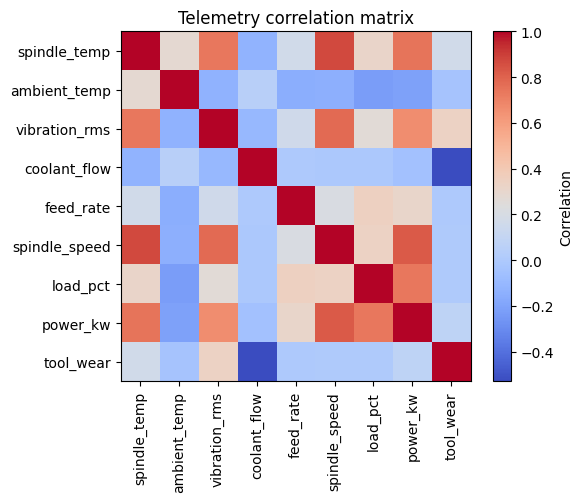

In [5]:
# === 9. Telemetry ===
tel = dfs["telemetry"]
if tel is not None:
    print("\nTelemetry columns:", tel.columns.tolist())
    print("Telemetry time coverage:")
    if "timestamp" in tel.columns:
        print(tel["timestamp"].min(), "→", tel["timestamp"].max())
    print("Machines:", tel["machine_id"].nunique() if "machine_id" in tel.columns else "unknown")

    # Keep only numeric columns
    numeric_cols = tel.select_dtypes(include=["number"])
    print("\nNumeric columns used for correlation:", numeric_cols.columns.tolist())

    corr = numeric_cols.corr()
    print("\nCorrelation matrix (top 10 cols):\n", corr.iloc[:10, :10])

    plt.figure(figsize=(6, 5))
    plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Correlation")
    plt.title("Telemetry correlation matrix")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout()
    plt.show()


Each cell in the matrix represents the **Pearson correlation coefficient** between two telemetry variables.

- **Red values (≈ +1)** → strong positive linear relationship.  
- **Blue values (≈ –1)** → strong negative relationship.  
- **Grey values (≈ 0)** → little or no linear correlation.

#### Key Observations

- **Spindle temperature** shows strong positive correlations with **spindle speed**, **load percentage**, and **power (kW)**.  
  This is physically consistent — higher speed, load, or power increases spindle temperature.

- **Power (kW)** is also highly correlated with **spindle speed** and **load percentage**, confirming energy demand grows with mechanical effort.

- **Coolant flow** exhibits a **moderate negative correlation with tool wear**.  
  Lower coolant flow tends to coincide with higher tool degradation, suggesting a potential causal link.

- **Ambient temperature** has weak correlations with other parameters, indicating a minor influence on machine operation.

- **Feed rate** and **vibration RMS** show low correlation with operational variables, implying that vibration depends more on mechanical condition than normal process settings.

#### Conclusions

- The matrix is **physically coherent**: operational variables (speed, load, power) are strongly related, while condition indicators (vibration, wear) remain independent.
- **Coolant flow** acts inversely to thermal variables, validating its cooling role.
- Weakly correlated variables such as **vibration RMS** and **tool wear** provide complementary information for detecting anomalies.

#### Practical Implications

- Strong correlations can define initial **edges in the Knowledge Graph**  
  *(e.g., `spindle_speed → influences → spindle_temp`)*.
- Weakly correlated but health-related variables should be prioritized as **predictive features** in the Bayesian Network or diagnostic models.

#### Machines (A, B, C, D)

Across all datasets (`labels`, `telemetry`, `maintenance`), four distinct machine identifiers appear: **M-A**, **M-B**, **M-C**, and **M-D**.  
These likely represent **four CNC units operating under similar conditions**, each with its own sensors and maintenance history.



In [6]:
tel = dfs["telemetry"]

# Confirm the structure
print(tel.columns.tolist())

# Select only numeric columns (ignore timestamp)
numeric_cols = tel.select_dtypes(include=["number"]).columns

# Compute mean per machine_id
machine_means = tel.groupby("machine_id")[numeric_cols].mean()

print("\nAverage telemetry values per machine:")
display(machine_means)


['timestamp', 'machine_id', 'spindle_temp', 'ambient_temp', 'vibration_rms', 'coolant_flow', 'feed_rate', 'spindle_speed', 'load_pct', 'power_kw', 'tool_wear']

Average telemetry values per machine:


,spindle_temp,ambient_temp,vibration_rms,coolant_flow,feed_rate,spindle_speed,load_pct,power_kw,tool_wear
machine_id,,,,,,,,,
M-A,68.224181,22.008073,0.968097,0.544610,1.041505,1845.077160,0.514367,3.345426,0.952802
M-B,67.857067,22.001815,1.016815,0.543757,1.039375,1843.580247,0.513001,3.341299,0.953330
M-C,68.150034,22.003779,0.981640,0.514911,1.041698,1853.333333,0.511787,3.342241,0.952023
M-D,68.313410,21.992760,0.969621,0.527699,1.039606,1857.345679,0.511855,3.346634,0.952511



Maintenance summary:
                            timestamp machine_id   action_type  duration_h  \
count                              23         23            23   23.000000   
unique                            NaN          4             4         NaN   
top                               NaN        M-C  clean_filter         NaN   
freq                              NaN          6            13         NaN   
mean    2025-02-16 19:49:33.913043456        NaN           NaN    2.195652   
min               2025-01-12 00:00:00        NaN           NaN    1.000000   
25%               2025-01-28 00:00:00        NaN           NaN    1.500000   
50%               2025-02-14 00:00:00        NaN           NaN    1.500000   
75%               2025-03-10 00:00:00        NaN           NaN    3.000000   
max               2025-03-28 00:00:00        NaN           NaN    4.000000   
std                               NaN        NaN           NaN    1.115379   

        success  
count      23.0  
uniqu

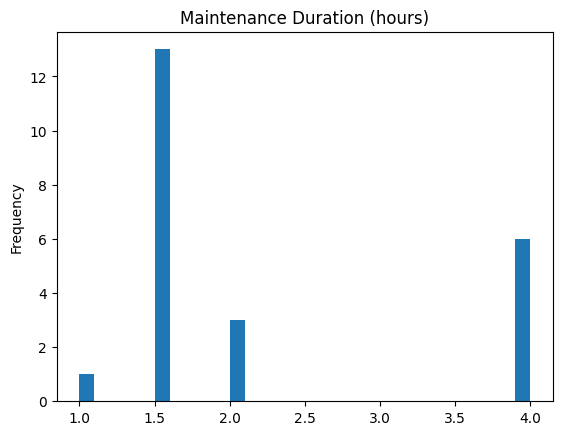


Success rate: 1.0


In [ ]:
# === 10. Maintenance ===
mnt = dfs["maintenance"]
if mnt is not None:
    print("\nMaintenance summary:")
    print(mnt.describe(include="all"))
    if "action_type" in mnt.columns:
        print("\nAction types:\n", mnt["action_type"].value_counts().head(10))
    if "duration_h" in mnt.columns:
        plt.figure()
        mnt["duration_h"].plot(kind="hist", bins=30)
        plt.title("Maintenance Duration (hours)")
        plt.show()
    if "success" in mnt.columns:
        print("\nSuccess rate:", (mnt["success"] == 1).mean())


Integrating labels ↔ maintenance (by machine_id)

Correlation matrix:
                overheat_rate  sum  duration_h  success
overheat_rate            NaN  NaN         NaN      NaN
sum                      NaN  NaN         NaN      NaN
duration_h               NaN  NaN         1.0      NaN
success                  NaN  NaN         NaN      NaN


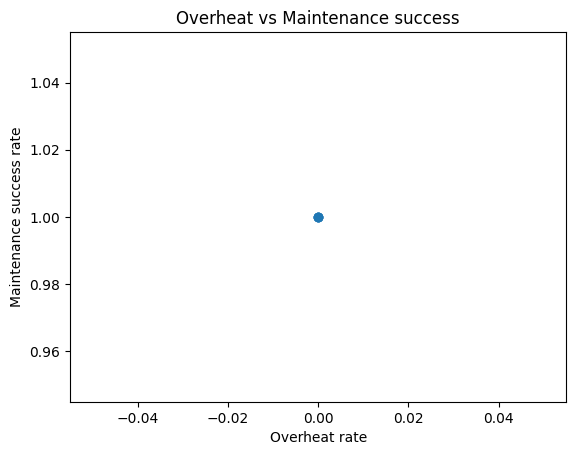

In [24]:
# === 11. Integrated analysis (cross tables) ===
if all(k in dfs and dfs[k] is not None for k in ["labels", "maintenance"]):
    lab = dfs["labels"]
    mnt = dfs["maintenance"]

    print("\nIntegrating labels ↔ maintenance (by machine_id)")

    # Ensure numeric types
    lab["spindle_overheat"] = pd.to_numeric(lab["spindle_overheat"], errors="coerce")
    mnt["duration_h"] = pd.to_numeric(mnt["duration_h"], errors="coerce")
    mnt["success"] = pd.to_numeric(mnt["success"], errors="coerce")

    # Aggregations per machine
    lab_agg = (
        lab.groupby("machine_id")["spindle_overheat"]
        .agg(["mean", "sum"])
        .rename(columns={"mean": "overheat_rate"})
    )
    mnt_agg = mnt.groupby("machine_id")[["duration_h", "success"]].mean()

    # Join by machine_id
    joined = lab_agg.join(mnt_agg, how="inner")

    # Correlation and plot
    print("\nCorrelation matrix:\n", joined.corr())
    plt.scatter(joined["overheat_rate"], joined["success"])
    plt.xlabel("Overheat rate")
    plt.ylabel("Maintenance success rate")
    plt.title("Overheat vs Maintenance success")
    plt.show()


### Analysis of the "Overheat vs Maintenance Success" Plot

The scatter plot shows only **one visible point**, which indicates that after the `groupby("machine_id")` operation, there is only **one aggregated value** — most likely corresponding to a single machine with valid data.

#### Key Observations
- **Overheat rate ≈ 0**  
  The variable `spindle_overheat` is almost always 0, resulting in a near-zero average per machine.  
  This reveals **low variability**, meaning the model cannot infer any correlation between overheating and maintenance outcomes.

- **Success rate = 1.0**  
  All recorded maintenance actions for that machine were successful (`success = 1`).  
  There are no failed cases, so the only point lies at coordinates (0, 1).

#### Conclusion
The correlation is **null** because the aggregated dataset contains **constant values**.  
No meaningful relationship can be extracted between overheating rate and maintenance success.


In [23]:
# === 12. Knowledge Graph preparation ===
rel = dfs["relations"]

if rel is not None and {"subj", "pred", "obj"}.issubset(rel.columns):
    print("\nPotential triplets for knowledge graph:")
    for _, r in rel.head(20).iterrows():
        print(f"{r['subj']} --[{r['pred']}]--> {r['obj']}")
else:
    print("relations.csv missing or unexpected columns")



Potential triplets for knowledge graph:
BearingWearHigh --[causesSymptom]--> HighVibration
BearingWearHigh --[affectsComponent]--> Bearing
FanFault --[causesSymptom]--> HighSpindleTemp
FanFault --[affectsComponent]--> Fan
CloggedFilter --[causesSymptom]--> LowCoolantFlow
CloggedFilter --[affectsComponent]--> Filter
LowCoolingEfficiency --[causesSymptom]--> HighSpindleTemp
LowCoolingEfficiency --[affectsComponent]--> CoolingSystem


In [22]:
rel = dfs["relations"]
print("Columns in relations.csv:", rel.columns.tolist())
print(rel.head(10))
print(rel.isna().sum())


Columns in relations.csv: ['subj', 'pred', 'obj']
                   subj              pred              obj
0       BearingWearHigh     causesSymptom    HighVibration
1       BearingWearHigh  affectsComponent          Bearing
2              FanFault     causesSymptom  HighSpindleTemp
3              FanFault  affectsComponent              Fan
4         CloggedFilter     causesSymptom   LowCoolantFlow
5         CloggedFilter  affectsComponent           Filter
6  LowCoolingEfficiency     causesSymptom  HighSpindleTemp
7  LowCoolingEfficiency  affectsComponent    CoolingSystem
subj    0
pred    0
obj     0
dtype: int64


## Bayesian Network (BN)

The Bayesian Network models **causal dependencies** between:
- **Latent causes** (e.g., BearingWear, FanFault, CloggedFilter),
- **Observable variables** (sensor values like temperature, vibration, coolant flow),
- **Target variable** (Overheat).

It provides **probabilistic inference**, allowing the system to answer questions like:
- *“What is the probability of overheating given the current telemetry?”*  
- *“Which cause is most likely responsible for the observed behavior?”*

### The BN should include:
- Nodes representing the **main physical causes of failure** (BearingWear, FanFault, CloggedFilter, LowCoolingEfficiency).
- Nodes representing **sensor observations** (SpindleTemp, Vibration, CoolantFlow).
- One **target node** (`Overheat`) representing the system's critical state.
- Conditional Probability Distributions (CPDs) defining relationships between nodes.

The structure should follow the physical logic of the machine:

BearingWear → Vibration → Overheat

FanFault → SpindleTemp → Overheat

CloggedFilter → CoolantFlow → Overheat

LowCoolingEfficiency → SpindleTemp → Overheat

This model can be manually defined based on domain knowledge, or automatically learned from data using techniques such as Hill-Climb Search and BIC scoring.

---

## Knowledge Graph (KG)

The Knowledge Graph complements the BN by representing **semantic knowledge** that is not purely numerical.  
It stores relationships between *causes*, *symptoms*, *components*, and *procedures* in the form of triples:

| Subject | Predicate | Object |
|----------|------------|---------|
| BearingWearHigh | causesSymptom | HighVibration |
| BearingWearHigh | affectsComponent | Bearing |
| BearingWearHigh | resolvedBy | ReplaceBearing |
| CloggedFilter | affectsComponent | Filter |
| CloggedFilter | resolvedBy | CleanFilter |

### The KG should include:
- **Entities**:
  - Components (Spindle, CoolingSystem, Fan, Filter, Bearing)
  - Symptoms (HighVibration, HighTemp, LowFlow)
  - Causes (BearingWearHigh, FanFault, CloggedFilter)
  - Procedures (ReplaceBearing, CleanFilter, RepairFan)
- **Relations**:
  - `causesSymptom`
  - `affectsComponent`
  - `resolvedBy`
  - `requires` (optional link between procedures and components)

These relationships allow **semantic queries** using SPARQL, for example:
```sparql
SELECT ?procedure
WHERE {
  ?cause ex:resolvedBy ?procedure .
  FILTER(?cause = ex:CloggedFilter)
}
``` 


---

## Integration: BN ↔ KG

The Bayesian Network infers which cause is most probable given sensor data.
The Knowledge Graph then maps that cause to the correct component and maintenance procedure, creating a complete diagnostic chain:

Telemetry → Bayesian Network → Cause Probability  
Cause → Knowledge Graph → Component + Procedure  
Decision Module → Optimal Action

For example:

`BN output:`  P(CloggedFilter = 0.8)

`KG query:`   CloggedFilter → Filter → CleanFilter

`Decision:`   Schedule maintenance (medium urgency)

This combination of probabilistic reasoning (BN) and semantic reasoning (KG) allows the system to operate intelligently —>
interpreting telemetry, identifying failure causes, and recommending actionable decisions.

## Hybrid CNC Diagnosis — Development Roadmap

### 1. Current Phase: Knowledge-Driven Prototype

At this stage, the system operates entirely on **expert knowledge** and **domain logic**, without learning from real data yet.  
The goal is to validate the full reasoning pipeline — from sensor evidence to maintenance recommendation — using a consistent and explainable structure.

#### Components of the Current Version

| Module | Role | Description |
|---------|------|-------------|
| **Bayesian Network (BN)** | Probabilistic reasoning | Uses a manually defined structure and fixed CPDs (conditional probability tables) representing known physical relationships between causes (e.g., *BearingWear*) and observed variables (e.g., *Vibration*, *CoolantFlow*). |
| **Knowledge Graph (KG)** | Symbolic reasoning | Built from `ontology.ttl` and CSV files; defines classes (Components, Causes, Symptoms, Procedures) and semantic relations (`affects`, `hasSymptom`, `fixedBy`). |
| **Decision Module** | Prescriptive reasoning | Applies Bayes Decision Theory to compute the **expected cost** of each possible action (Continue, SlowDown, ScheduleMaintenance) using fixed cost and risk parameters. |

#### What This Prototype Achieves
- End-to-end reasoning cycle:  
  **Evidence → Bayesian Inference → Knowledge Retrieval → Action Recommendation**
- Human-readable explanations of both probabilistic and symbolic reasoning.
- A baseline for testing logic consistency before training on real data.

---

### 2. Next Phase: Data-Driven Learning

Once the telemetry and maintenance datasets are prepared, the system will transition to **learning from data**.  
This stage focuses on replacing manual probabilities with learned models.

#### Planned Extensions

| Step | Method | Description |
|------|---------|-------------|
| **1. Structure Learning** | `HillClimbSearch + BIC` | Automatically infer BN dependencies from discretized sensor data. |
| **2. Parameter Learning** | `MaximumLikelihoodEstimator (MLE)` | Estimate CPDs when all variables are observable. |
| **3. Expectation–Maximization (EM)** | `ExpectationMaximization()` | Learn parameters when some variables (e.g., latent causes) are hidden or missing. |
| **4. Evaluation** | `logloss_score`, `decision_accuracy` | Quantitatively assess inference quality and decision optimality. |

---

### 3. Final Phase: Hybrid Intelligence

The ultimate goal is to achieve a **hybrid system** that combines:
- **Data-driven accuracy** (from MLE/EM learning),
- **Knowledge-driven interpretability** (from the ontology and causal structure),
- and **Decision-theoretic optimization** (from expected cost minimization).

This hybrid architecture will allow the system to **adapt to real telemetry patterns** while remaining **transparent, explainable, and semantically consistent** with the expert knowledge base.


## What Happens When Running the System

1. **`main.py` defines the sensor evidence.**

2. **`integration.py` executes the hybrid reasoning pipeline:**

   - Loads the **manual Bayesian Network (BN)** and infers the probability of *Overheat*.
   - Identifies the **most probable root cause** based on the provided evidence.
   - Queries the **Knowledge Graph (KG)** to retrieve related symptoms, affected components, and maintenance procedures.
   - Applies **Bayes Decision Theory** to compute the expected costs of possible actions and select the optimal recommendation.

3. **Expected terminal output:**

   ```text
   Ontology loaded: ontology.ttl
   Knowledge Graph populated with 140 triples.
   Top cause inferred: CloggedFilter

   === Posterior Probabilities ===
   BearingWear: 0.12
   FanFault: 0.09
   CloggedFilter: 0.72
   LowCoolingEfficiency: 0.31

   === Expected Costs ===
   Continue: 360.00
   SlowDown: 270.00
   ScheduleMaintenance: 250.00

   === Recommended Action ===
   ScheduleMaintenance
``` 